In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# !pip uninstall tensorflow
# !pip install tensorflow==2.2.0 tensorflow-gpu==2.2.0
# !pip install gensim==3.8.3

In [ ]:
import tensorflow as tf
tf.random.set_seed(1)
tf.compat.v1.enable_eager_execution()

import numpy as np
np.random.seed(1)

import gensim
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense, \
    SpatialDropout1D, Bidirectional, Conv1D, concatenate
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import Callback

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, confusion_matrix

%matplotlib inline

In [ ]:
print(tf.test.gpu_device_name())

/device:GPU:0


In [ ]:
df = pd.read_csv('drive/My Drive/NER/data/data.csv')

In [ ]:
df.head()

,word,tag
0,Pengamat,O
1,politik,O
2,dari,O
3,Universitas,B-ORGANIZATION
4,Gadjah,I-ORGANIZATION


In [ ]:
sentences = []
cnt = 1

for i in df.itertuples():
    sentences.append(cnt)
    
    if '.' in str(i.word):
        cnt += 1
        
df['sentence #'] = sentences
df.head()

,word,tag,sentence #
0,Pengamat,O,1
1,politik,O,1
2,dari,O,1
3,Universitas,B-ORGANIZATION,1
4,Gadjah,I-ORGANIZATION,1


In [ ]:
agg_func = lambda s: [(w, t) for w, t in zip(s['word'].values.tolist(), s['tag'].values.tolist())]
grouped = df.groupby('sentence #').apply(agg_func)
sentences = [s for s in grouped]

In [ ]:
words = list(set(df['word'].values))
words.append('PADDING')
num_words = len(words)
tags = list(set(df['tag'].values))
num_tags = len(tags)

In [ ]:
tags = sorted([t for t in tags if t != 'O'], key=lambda x: (x[2], x[0]))
tags.append('O')

In [ ]:
word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [ ]:
tag2idx

{'B-LOCATION': 0,
 'B-ORGANIZATION': 4,
 'B-PERSON': 8,
 'B-QUANTITY': 12,
 'B-TIME': 16,
 'I-LOCATION': 1,
 'I-ORGANIZATION': 5,
 'I-PERSON': 9,
 'I-QUANTITY': 13,
 'I-TIME': 17,
 'L-LOCATION': 2,
 'L-ORGANIZATION': 6,
 'L-PERSON': 10,
 'L-QUANTITY': 14,
 'L-TIME': 18,
 'O': 20,
 'U-LOCATION': 3,
 'U-ORGANIZATION': 7,
 'U-PERSON': 11,
 'U-QUANTITY': 15,
 'U-TIME': 19}

### Pad Sequence

In [ ]:
max_len = 40
X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_len, sequences=X, padding='post', value=num_words-1)

y = [[tag2idx[w[1]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding='post', value=tag2idx['O'])
y = [to_categorical(i, num_classes=num_tags) for i in y]

In [ ]:
x_train, x_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.3, random_state=1)
x_val, x_test, y_val, y_test = train_test_split(x_val_test, y_val_test, test_size=0.5, random_state=1)

### Pre-trained Word2Vec Embedding

In [ ]:
model = gensim.models.Word2Vec.load("drive/My Drive/NER/checkpoint/w2vec_wiki_id_case")

In [ ]:
embedding_matrix = np.zeros((len(words), 400))

for i, w in enumerate(words):
    try:
        embedding_vector = model.wv[w]
        embedding_matrix[i] = embedding_vector
    except:
        embedding_matrix[i] = np.random.normal(0, np.sqrt(0.25), 400)

In [ ]:
def get_report(model, history):
    # plot loss
    fig=plt.figure(figsize=(7,5))
    plt.plot(history.history['loss'], "-o")
    plt.plot(history.history['val_loss'], "-o")
    plt.title('loss')
    plt.xlabel('epoch')
    plt.ylim(0,1)
    plt.show();
    
    print()
    # plot f1 score
    fig=plt.figure(figsize=(7,5))
    plt.plot(history.history['f1_score_micro'], "-o")
    plt.plot(history.history['val_f1_score_micro'], "-o")
    plt.title('f1_micro')
    plt.xlabel('epoch')
    plt.ylim(0,1)
    plt.show();
    
    print()
    # f1 score micro average
    actuals = np.argmax(np.array(y_test), axis=-1).reshape(-1)
    preds = model.predict(x_test)
    preds = np.argmax(preds, axis=-1).reshape(-1)

    score = f1_score(actuals, preds, average='micro')

    print('f1 score micro average include label O:', score)
    
    print()
    # print classification report
    report = classification_report(actuals, preds, target_names=tags, output_dict=True, )
    print(report)
    
    print()
    # f1 score micro average
    actuals = np.argmax(np.array(y_test), axis=-1).reshape(-1)
    preds = model.predict(x_test)
    preds = np.argmax(preds, axis=-1).reshape(-1)

    o_pad_idx = np.where(actuals==20)

    actuals = np.delete(actuals, o_pad_idx)
    preds = np.delete(preds, o_pad_idx)

    score = f1_score(actuals, preds, average='micro')

    print('f1 score micro average without label O:', score)
    
    print()
    # plot confusion matrix
    fig, ax = plt.subplots(figsize=(10,10))

    cm_matrix = confusion_matrix(actuals, preds)
    cm_matrix = np.delete(cm_matrix, (20), axis=0)
    cm_matrix = np.delete(cm_matrix, (20), axis=1)

    ax.matshow(cm_matrix, cmap=plt.cm.Blues)

    for i in range(num_tags-1):
        for j in range(num_tags-1):
            c = cm_matrix[j,i]
            ax.text(i, j, str(c), va='center', ha='center')

    plt.xticks(range(num_tags-1),['{} ({})'.format(tags[:-1][i],i) for i in range(num_tags-1)])
    plt.yticks(range(num_tags-1),['{} ({})'.format(tags[:-1][i],i) for i in range(num_tags-1)])
    plt.xticks(rotation=90)
    plt.show();

    return report

In [ ]:
def f1_score_micro(y_true, y_pred):
    y_true = np.argmax(y_true.numpy(), axis=-1).reshape(-1)
    y_pred = np.argmax(y_pred.numpy(), axis=-1).reshape(-1)
    
    # label O will be ignored during training and evaluation
    o_pad_idx = np.where(y_true==20) # 20 is the idx for label O
    
    # remove label O
    y_true = np.delete(y_true, o_pad_idx)
    y_pred = np.delete(y_pred, o_pad_idx)
    
    # compute f1 score with with micro average
    score = f1_score(y_true, y_pred, average='micro')
    
    return score

In [ ]:
def create_model(params, w2v=False, cnn=False):
    input_sequence = Input(shape=(max_len, ))
    
    # embedding layer
    if w2v:
        model = Embedding(
            input_dim= embedding_matrix.shape[0], 
            weights=[embedding_matrix], 
            output_dim=embedding_matrix.shape[1], 
            input_length=max_len,
            trainable=False
        )(input_sequence)
    else:
        model = Embedding(
            input_dim=num_words,
            output_dim=400,
            input_length=max_len,
        )(input_sequence)
    
    # dropout layer
    model = SpatialDropout1D(0.1)(model)
    
    # convolution layer
    if cnn:
        if len(params['filters']) == 1:
            model = Conv1D(params['filters'][0], params['filter_size'][0], activation='relu', padding='same')(model)
        else:
            cnns = []
            for i, _ in enumerate(params['filters']):
                cnns.append(Conv1D(
                    params['filters'][i], params['filter_size'][i], 
                    activation='relu', padding='same')(model))
            
            model = concatenate(cnns)
            
    # lstm layer
    model = Bidirectional(LSTM(units=100, return_sequences=True))(model)
    
    # output layer
    output_sequence = Dense(num_tags, activation='softmax')(model)
    
    # model
    model = Model(input_sequence, output_sequence)
    
    # learning algorithm (optimizer)
    if params['optimizer'] == 'Nadam':
        optm = tf.keras.optimizers.Nadam(lr=params['lr'])
        
    if params['optimizer'] == 'Adam':
        optm = tf.keras.optimizers.Adam(lr=params['lr'])
        
    if params['optimizer'] == 'RMSprop':
        optm = tf.keras.optimizers.RMSprop(lr=params['lr'])
    
    loss = tf.keras.losses.CategoricalCrossentropy()

    model.compile(loss=loss, optimizer=optm, metrics=[f1_score_micro], run_eagerly=True)
    
    return model

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_f1_score_micro', mode='max')

### BiLSTM + w2v

In [ ]:
params = {
    'optimizer': 'Adam',
    'lr': 0.01,
    'lstm_units': 200,
    'dropout': 0.7,
    'batch_size': 128
}

In [ ]:
bilstm_w2v = create_model(params, w2v=True)

In [ ]:
bilstm_w2v.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 40)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 40, 400)           5212400   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 40, 400)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 40, 200)           400800    
_________________________________________________________________
dense (Dense)                (None, 40, 21)            4221      
Total params: 5,617,421
Trainable params: 405,021
Non-trainable params: 5,212,400
_________________________________________________________________


In [ ]:
%%time

bilstm_w2v_history = bilstm_w2v.fit(
    x_train, np.array(y_train),
    validation_data=(x_val, np.array(y_val)),
    epochs=100, verbose=1, callbacks=[early_stopping], batch_size=params['batch_size']
)

Epoch 1/100
27/27 [==============================] - 1s 35ms/step - loss: 0.5391 - f1_score_micro: 0.0069 - val_loss: 0.3624 - val_f1_score_micro: 0.0169
Epoch 2/100
27/27 [==============================] - 1s 35ms/step - loss: 0.3127 - f1_score_micro: 0.0894 - val_loss: 0.2588 - val_f1_score_micro: 0.2016
Epoch 3/100
27/27 [==============================] - 1s 38ms/step - loss: 0.2238 - f1_score_micro: 0.3011 - val_loss: 0.1932 - val_f1_score_micro: 0.4620
Epoch 4/100
27/27 [==============================] - 1s 35ms/step - loss: 0.1629 - f1_score_micro: 0.5076 - val_loss: 0.1526 - val_f1_score_micro: 0.6048
Epoch 5/100
27/27 [==============================] - 1s 35ms/step - loss: 0.1295 - f1_score_micro: 0.6218 - val_loss: 0.1371 - val_f1_score_micro: 0.6237
Epoch 6/100
27/27 [==============================] - 1s 34ms/step - loss: 0.1104 - f1_score_micro: 0.6766 - val_loss: 0.1325 - val_f1_score_micro: 0.6759
Epoch 7/100
27/27 [==============================] - 1s 35ms/step - loss: 0.

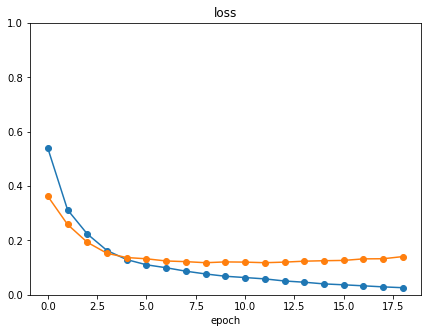

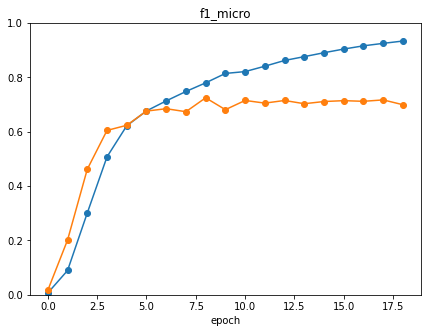


f1 score micro average include label O: 0.9672683923705722

{'B-LOCATION': {'precision': 0.7226890756302521, 'recall': 0.7288135593220338, 'f1-score': 0.7257383966244726, 'support': 118}, 'I-LOCATION': {'precision': 0.7358490566037735, 'recall': 0.48148148148148145, 'f1-score': 0.5820895522388059, 'support': 81}, 'L-LOCATION': {'precision': 0.8073394495412844, 'recall': 0.7521367521367521, 'f1-score': 0.7787610619469026, 'support': 117}, 'U-LOCATION': {'precision': 0.8347826086956521, 'recall': 0.7773279352226721, 'f1-score': 0.8050314465408805, 'support': 247}, 'B-ORGANIZATION': {'precision': 0.704, 'recall': 0.6666666666666666, 'f1-score': 0.6848249027237353, 'support': 132}, 'I-ORGANIZATION': {'precision': 0.575, 'recall': 0.4423076923076923, 'f1-score': 0.5, 'support': 104}, 'L-ORGANIZATION': {'precision': 0.6890756302521008, 'recall': 0.6119402985074627, 'f1-score': 0.6482213438735178, 'support': 134}, 'U-ORGANIZATION': {'precision': 0.6929133858267716, 'recall': 0.70682730923694

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


f1 score micro average without label O: 0.7044976881042455



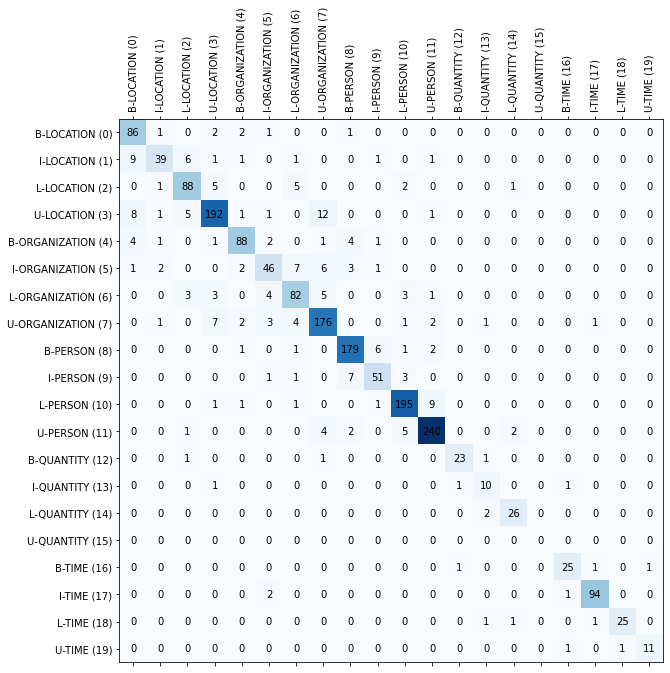

In [ ]:
report = get_report(bilstm_w2v, bilstm_w2v_history)

In [ ]:
pd.DataFrame(report).transpose().to_csv('bilstm_w2v.csv')

### BiLSTM-CNNs + w2v

In [ ]:
params = {
    'optimizer': 'Adam',
    'lr': 0.01,
    'lstm_units': 50,
    'filters': [64],
    'filter_size': [3],
    'dropout': 0.7,
    'batch_size': 128
}

In [ ]:
bilstm_cnns_w2v = create_model(params, w2v=True, cnn=True)

In [ ]:
bilstm_cnns_w2v.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 40)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 40, 400)           5212400   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 40, 400)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 40, 64)            76864     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 40, 200)           132000    
_________________________________________________________________
dense_1 (Dense)              (None, 40, 21)            4221      
Total params: 5,425,485
Trainable params: 213,085
Non-trainable params: 5,212,400
___________________________________________

In [ ]:
%%time

bilstm_cnns_w2v_history = bilstm_cnns_w2v.fit(
    x_train, np.array(y_train),
    validation_data=(x_val, np.array(y_val)),
    epochs=100, verbose=1, callbacks=[early_stopping], batch_size=params['batch_size']
)

Epoch 1/100
27/27 [==============================] - 1s 48ms/step - loss: 0.5649 - f1_score_micro: 0.0074 - val_loss: 0.3761 - val_f1_score_micro: 0.0023
Epoch 2/100
27/27 [==============================] - 1s 37ms/step - loss: 0.3212 - f1_score_micro: 0.0557 - val_loss: 0.2708 - val_f1_score_micro: 0.1625
Epoch 3/100
27/27 [==============================] - 1s 41ms/step - loss: 0.2417 - f1_score_micro: 0.2275 - val_loss: 0.2088 - val_f1_score_micro: 0.3614
Epoch 4/100
27/27 [==============================] - 1s 37ms/step - loss: 0.1911 - f1_score_micro: 0.3962 - val_loss: 0.1751 - val_f1_score_micro: 0.4808
Epoch 5/100
27/27 [==============================] - 1s 41ms/step - loss: 0.1528 - f1_score_micro: 0.5361 - val_loss: 0.1471 - val_f1_score_micro: 0.5910
Epoch 6/100
27/27 [==============================] - 1s 38ms/step - loss: 0.1311 - f1_score_micro: 0.6173 - val_loss: 0.1367 - val_f1_score_micro: 0.6449
Epoch 7/100
27/27 [==============================] - 1s 41ms/step - loss: 0.

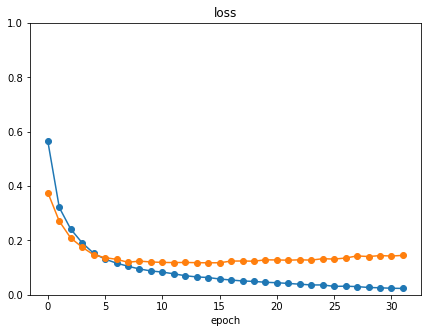

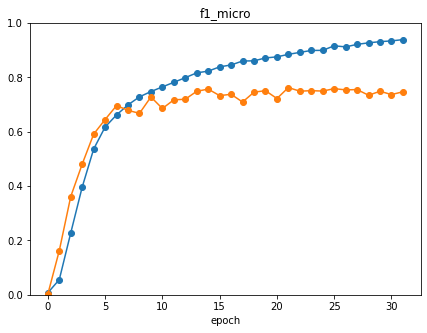


f1 score micro average include label O: 0.9650544959128066

{'B-LOCATION': {'precision': 0.7909090909090909, 'recall': 0.7372881355932204, 'f1-score': 0.7631578947368423, 'support': 118}, 'I-LOCATION': {'precision': 0.8125, 'recall': 0.48148148148148145, 'f1-score': 0.6046511627906976, 'support': 81}, 'L-LOCATION': {'precision': 0.8333333333333334, 'recall': 0.7692307692307693, 'f1-score': 0.8, 'support': 117}, 'U-LOCATION': {'precision': 0.8277310924369747, 'recall': 0.7975708502024291, 'f1-score': 0.8123711340206186, 'support': 247}, 'B-ORGANIZATION': {'precision': 0.6143790849673203, 'recall': 0.7121212121212122, 'f1-score': 0.6596491228070176, 'support': 132}, 'I-ORGANIZATION': {'precision': 0.6989247311827957, 'recall': 0.625, 'f1-score': 0.6598984771573605, 'support': 104}, 'L-ORGANIZATION': {'precision': 0.6470588235294118, 'recall': 0.6567164179104478, 'f1-score': 0.6518518518518519, 'support': 134}, 'U-ORGANIZATION': {'precision': 0.6460905349794238, 'recall': 0.6305220883534

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


f1 score micro average without label O: 0.7137452711223203



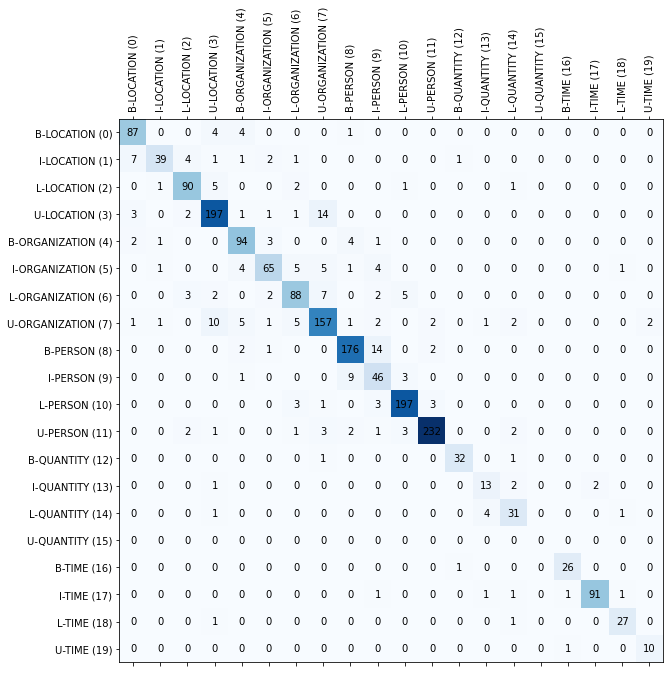

In [ ]:
report = get_report(bilstm_cnns_w2v, bilstm_cnns_w2v_history)

In [ ]:
pd.DataFrame(report).transpose().to_csv('bilstm_cnns_w2v.csv')

### BiLSTM-CNNs + multi-sequence n-gram + w2v

In [ ]:
multi_cnns_params = {
    'optimizer': 'Adam',
    'lr': 0.01,
    'lstm_units': 100,
    'filters': [64, 64, 64, 64, 64],
    'filter_size': [2, 4, 6, 8, 10],
    'dropout': 0.7,
    'batch_size': 128
}

In [ ]:
bilstm_multi_cnns_w2v = create_model(multi_cnns_params, w2v=True, cnn=True)

In [ ]:
bilstm_multi_cnns_w2v.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 40, 400)      5212400     input_3[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_2 (SpatialDro (None, 40, 400)      0           embedding_2[0][0]                
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 40, 64)       51264       spatial_dropout1d_2[0][0]        
____________________________________________________________________________________________

In [ ]:
%%time

bilstm_multi_cnns_w2v_history = bilstm_multi_cnns_w2v.fit(
    x_train, np.array(y_train),
    validation_data=(x_val, np.array(y_val)),
    epochs=100, verbose=1, callbacks=[early_stopping], batch_size=multi_cnns_params['batch_size']
)

Epoch 1/100
27/27 [==============================] - 2s 89ms/step - loss: 0.5483 - f1_score_micro: 9.0555e-04 - val_loss: 0.3834 - val_f1_score_micro: 0.0000e+00
Epoch 2/100
27/27 [==============================] - 1s 53ms/step - loss: 0.3392 - f1_score_micro: 0.0425 - val_loss: 0.3062 - val_f1_score_micro: 0.1095
Epoch 3/100
27/27 [==============================] - 1s 51ms/step - loss: 0.2721 - f1_score_micro: 0.1996 - val_loss: 0.2586 - val_f1_score_micro: 0.2260
Epoch 4/100
27/27 [==============================] - 1s 52ms/step - loss: 0.2214 - f1_score_micro: 0.3431 - val_loss: 0.2137 - val_f1_score_micro: 0.4115
Epoch 5/100
27/27 [==============================] - 1s 52ms/step - loss: 0.1808 - f1_score_micro: 0.4716 - val_loss: 0.1936 - val_f1_score_micro: 0.5080
Epoch 6/100
27/27 [==============================] - 1s 54ms/step - loss: 0.1536 - f1_score_micro: 0.5494 - val_loss: 0.1746 - val_f1_score_micro: 0.5523
Epoch 7/100
27/27 [==============================] - 1s 54ms/step - 

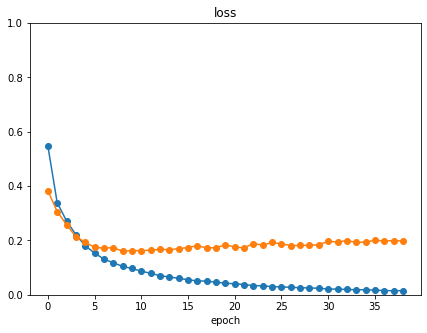

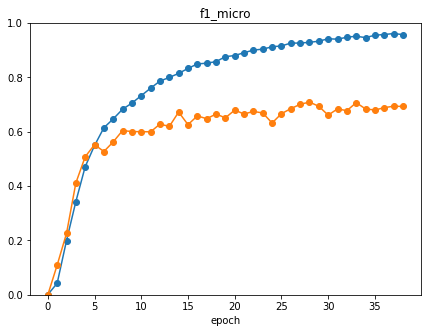


f1 score micro average include label O: 0.9601839237057221

{'B-LOCATION': {'precision': 0.7623762376237624, 'recall': 0.652542372881356, 'f1-score': 0.7031963470319635, 'support': 118}, 'I-LOCATION': {'precision': 0.6842105263157895, 'recall': 0.48148148148148145, 'f1-score': 0.5652173913043478, 'support': 81}, 'L-LOCATION': {'precision': 0.8229166666666666, 'recall': 0.6752136752136753, 'f1-score': 0.7417840375586855, 'support': 117}, 'U-LOCATION': {'precision': 0.7818181818181819, 'recall': 0.6963562753036437, 'f1-score': 0.7366167023554605, 'support': 247}, 'B-ORGANIZATION': {'precision': 0.6642857142857143, 'recall': 0.7045454545454546, 'f1-score': 0.6838235294117647, 'support': 132}, 'I-ORGANIZATION': {'precision': 0.5392156862745098, 'recall': 0.5288461538461539, 'f1-score': 0.5339805825242718, 'support': 104}, 'L-ORGANIZATION': {'precision': 0.6212121212121212, 'recall': 0.6119402985074627, 'f1-score': 0.6165413533834586, 'support': 134}, 'U-ORGANIZATION': {'precision': 0.6756

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


f1 score micro average without label O: 0.6725514922236234



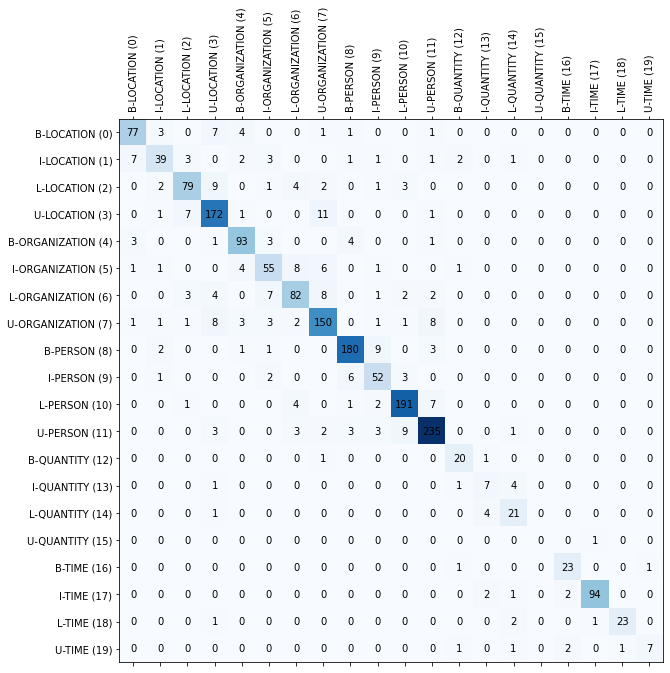

In [ ]:
report = get_report(bilstm_multi_cnns_w2v, bilstm_multi_cnns_w2v_history)

In [ ]:
pd.DataFrame(report).transpose().to_csv('bilstm_multi_cnns_w2v.csv')